In [ ]:
from tensorflow.keras import backend as K
K.clear_session()
!pip install rarfile
import os
import pandas as pd
import gdown
import rarfile
import shutil
from PIL import Image

#
#https://drive.google.com/file/d/1ATotTLVBrB3tNlj4NRcV4WzqR24UUkJ3/view?usp=drive_link
#https://drive.google.com/file/d/1OGuEqyNj4aSPSW16wavw13jmp5PXS_b3/view?usp=sharing
url = 'https://drive.google.com/uc?id=1ATotTLVBrB3tNlj4NRcV4WzqR24UUkJ3'
output_rar = '/content/SDR.rar'
gdown.download(url, output_rar, quiet=False)
# Extract the RAR file
with rarfile.RarFile(output_rar, 'r') as rar_ref:
    rar_ref.extractall('/content')
# Path to the extracted dataset folder
dataset_folder = '/content/SDR'

Downloading...
From (original): https://drive.google.com/uc?id=1ATotTLVBrB3tNlj4NRcV4WzqR24UUkJ3
From (redirected): https://drive.google.com/uc?id=1ATotTLVBrB3tNlj4NRcV4WzqR24UUkJ3&confirm=t&uuid=3f733ff7-3bf2-4279-8bf0-ebbb3bdf861b
To: /content/SDR.rar
100%|██████████| 231M/231M [00:04<00:00, 46.5MB/s]


# ResNet-18 using SWISH

In [ ]:
#ResNet-18 A refined ResNet18 architecture with swish SERENA2023
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, GlobalAveragePooling2D, Flatten, Dense

# Define the Swish activation function
def swish(x):
    return x * tf.keras.backend.sigmoid(x)
# Define the CNN architecture
input_shape = (224, 224, 3)
num_classes = 2  # Change this to the number of classes in your problem

# Input
inputs = Input(shape=input_shape)

# Initial convolution layer
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation(swish)(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Residual blocks
num_blocks = [2, 2, 2, 2]  # Number of residual blocks in each stage

for stage in range(4):
    for block in range(num_blocks[stage]):
        # First residual block in each stage has a stride of 2
        if stage > 0 and block == 0:
            strides = (2, 2)
        else:
            strides = (1, 1)

        # Convolutional block
        y = Conv2D(64 * 2**stage, (3, 3), strides=strides, padding='same')(x)
        y = BatchNormalization()(y)
        y = Activation(swish)(y)

        # Convolutional block
        y = Conv2D(64 * 2**stage, (3, 3), padding='same')(y)
        y = BatchNormalization()(y)

        # Shortcut connection
        if strides == (2, 2) or x.shape[-1] != y.shape[-1]:
            x = Conv2D(64 * 2**stage, (1, 1), strides=strides, padding='same')(x)
            x = BatchNormalization()(x)

        # Add the shortcut to the main path
        x = Add()([x, y])
        x = Activation(swish)(x)

# Global average pooling and final dense layer
x = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Create the ResNet-18 model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 64)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 11,191,938 (42.69 MB)

 Trainable params: 11,182,338 (42.66 MB)

 Non-trainable params: 9,600 (37.50 KB)

# **Fold#1** ResNet-18

Found 2673 images belonging to 2 classes.
Found 667 images belonging to 2 classes.
Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9964 - loss: 0.0088
Epoch 1: val_accuracy improved from -inf to 0.92654, saving model to /content/Split/Save/best_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 52s 388ms/step - accuracy: 0.9964 - loss: 0.0089 - val_accuracy: 0.9265 - val_loss: 0.4443
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9879 - loss: 0.0332
Epoch 2: val_accuracy improved from 0.92654 to 0.94903, saving model to /content/Split/Save/best_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 25s 279ms/step - accuracy: 0.9879 - loss: 0.0331 - val_accuracy: 0.9490 - val_loss: 0.3331
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9932 - loss: 0.0173
Epoch 3: val_accuracy did not improve from 0.94903
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.9931 - loss: 0.0173 - val_accuracy: 0.9355 - val_loss: 0.3637
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0

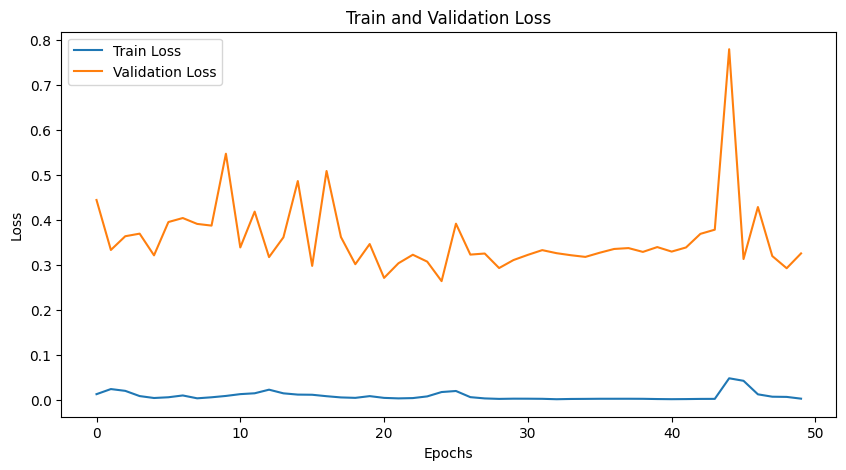

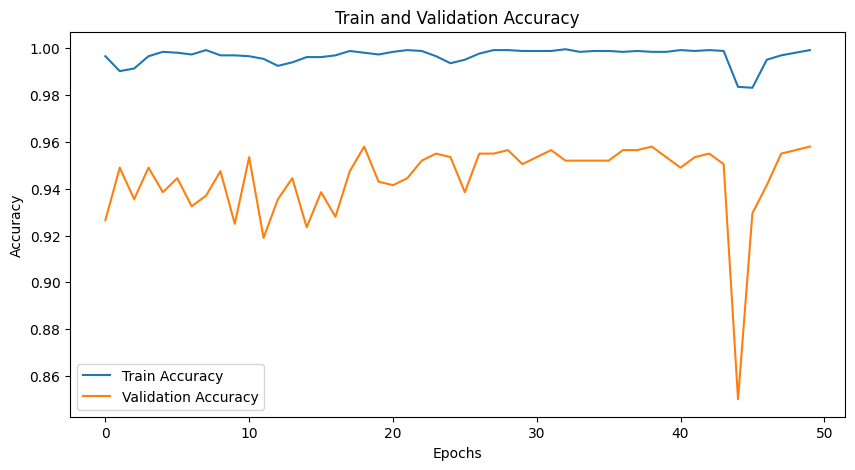

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Load and preprocess the images
data_dir = '/content/SDS/Train'
class_names = ['DR', 'NDR']
img_size = (224, 224)
batch_size = 32
epochs = 50
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create the data generator for training set
train_data_generator = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True, subset='training')

# Create the data generator for validation set
validation_data_generator = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True, subset='validation')

# Assuming the model is already defined before compiling
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint callback to save best weights based on validation accuracy
# Define the ModelCheckpoint callback to save best weights based on validation accuracy
best_weights_path = '/content/Split/Save/best_model.keras'
checkpoint = ModelCheckpoint(best_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model and get the training history
history = model.fit(train_data_generator, epochs=epochs, validation_data=validation_data_generator, verbose=1, callbacks=[checkpoint])

# Plot train and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

# Plot train and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.show()

In [ ]:
# Helper function to evaluate the model on given test generator
def evaluate_model(test_generator, model, classes, title="Performance"):
    y_test_pred = model.predict(test_generator)
    y_test_pred = np.argmax(y_test_pred, axis=1)

    precision = precision_score(test_generator.labels, y_test_pred, average='weighted')
    recall = recall_score(test_generator.labels, y_test_pred, average='weighted')
    f1 = f1_score(test_generator.labels, y_test_pred, average='weighted')
    accuracy = accuracy_score(test_generator.labels, y_test_pred)

    print(f"\n{title}")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)

    # Display the confusion matrix
    confusion = confusion_matrix(test_generator.labels, y_test_pred)
    confusion_df = pd.DataFrame(confusion, index=classes, columns=classes)
    print("Confusion Matrix:\n", confusion_df)

# Calculate and display TP, FN, FP, TN for each class
    print("\nClass-wise metrics:")
    cm = multilabel_confusion_matrix(test_generator.labels, y_test_pred)

    for idx, class_name in enumerate(classes):
        tn, fp, fn, tp = cm[idx].ravel()
        class_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        class_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        class_f1 = (2 * class_precision * class_recall) / (class_precision + class_recall) if (class_precision + class_recall) > 0 else 0

        print(f"\nClass: {class_name}")
        print(f"TP: {tp}, FN: {fn}, FP: {fp}, TN: {tn}")
        print(f"Precision: {class_precision:.2f}")
        print(f"Recall: {class_recall:.2f}")
        print(f"F1 Score: {class_f1:.2f}")

# Test the model on the test set
evaluate_model(test_generator, model, ["DR", "NDR"], title="Performance on Test Data")

NameError: name 'test_generator' is not defined

# Fold#1 Test ResNet-18

In [ ]:
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved best weights
best_weights_path = '/content/Split/Save/best_model.keras'
model.load_weights(best_weights_path)

# Define the dataset directory
TestSet = '/content/SDS/Test'

# Create an ImageDataGenerator for test data
datagen = ImageDataGenerator(rescale=1.0/255)  # You can add other preprocessing steps here

test_data_generator = datagen.flow_from_directory(
    TestSet,
    target_size=img_size,  # Set your target image size (e.g., (224, 224))
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle the test data
)

# Get true labels and predicted labels
y_true = test_data_generator.classes
y_pred = np.argmax(model.predict(test_data_generator), axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Found 836 images belonging to 2 classes.
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step
Test Accuracy: 0.930622009569378
Test Precision: 0.930778114405142
Test Recall: 0.930622009569378
Test F1-score: 0.9305661689423786
Confusion Matrix:
[[417  24]
 [ 34 361]]


## ResNet50

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, AveragePooling2D, Flatten, Dense

def conv_block(inputs, filters, kernel_size, strides=(1, 1)):
    x = Conv2D(filters=filters[0], kernel_size=(1, 1), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[2], kernel_size=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters=filters[2], kernel_size=(1, 1), strides=strides, padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def identity_block(inputs, filters):
    x = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[2], kernel_size=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, inputs])
    x = Activation('relu')(x)
    return x

def resnet_50():
    inputs = Input(shape=(224, 224, 3))

    # Initial layers
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = conv_block(x, [64, 64, 256], (3, 3))
    for _ in range(2):
        x = identity_block(x, [64, 64, 256])

    x = conv_block(x, [128, 128, 512], (3, 3), strides=(2, 2))
    for _ in range(3):
        x = identity_block(x, [128, 128, 512])

    x = conv_block(x, [256, 256, 1024], (3, 3), strides=(2, 2))
    for _ in range(5):
        x = identity_block(x, [256, 256, 1024])

    x = conv_block(x, [512, 512, 2048], (3, 3), strides=(2, 2))
    for _ in range(2):
        x = identity_block(x, [512, 512, 2048])

    # Final layers
    x = AveragePooling2D((7, 7))(x)
    x = Flatten()(x)
    outputs = Dense(5, activation='softmax')(x)

    resnet50 = Model(inputs=inputs, outputs=outputs)
    resnet50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return resnet50

model = resnet_50()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 112, 112, 64)   │          9,472 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 112, 112, 64)   │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 112, 112, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ activation_17[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 56, 56, 64)     │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 56, 56, 64)     │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 56, 56, 256)    │         16,640 │ activation_19[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 56, 56, 256)    │         16,640 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 56, 56, 256)    │          1,024 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 56, 56, 256)    │          1,024 │ conv2d_24[0][0]        │
│ (BatchNormalization) 

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

# **Fold#1** Train ResNet-50

Found 669 images belonging to 2 classes.
Found 167 images belonging to 2 classes.
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.6779 - loss: 0.7541
Epoch 1: val_accuracy improved from -inf to 0.88024, saving model to /content/Split/Save/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 956ms/step - accuracy: 0.6816 - loss: 0.7446 - val_accuracy: 0.8802 - val_loss: 0.2436
Epoch 2/50
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8390 - loss: 0.3446
Epoch 2: val_accuracy did not improve from 0.88024
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8399 - loss: 0.3434 - val_accuracy: 0.8802 - val_loss: 0.2626
Epoch 3/50
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8640 - loss: 0.2961
Epoch 3: val_accuracy improved from 0.88024 to 0.91018, saving model to /content/Split/Save/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 833ms/step - accuracy: 0.8638 - loss: 0.2980 - val_accuracy: 0.9102 - val_loss: 0.2631
Epoch 4/50
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 80m

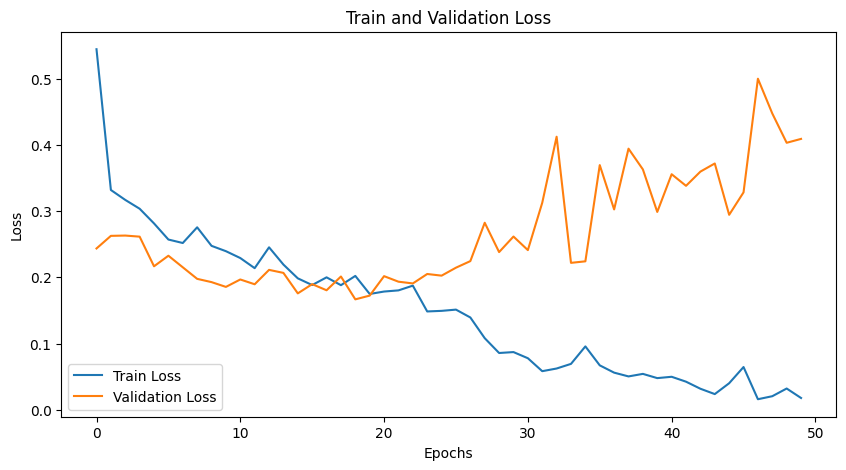

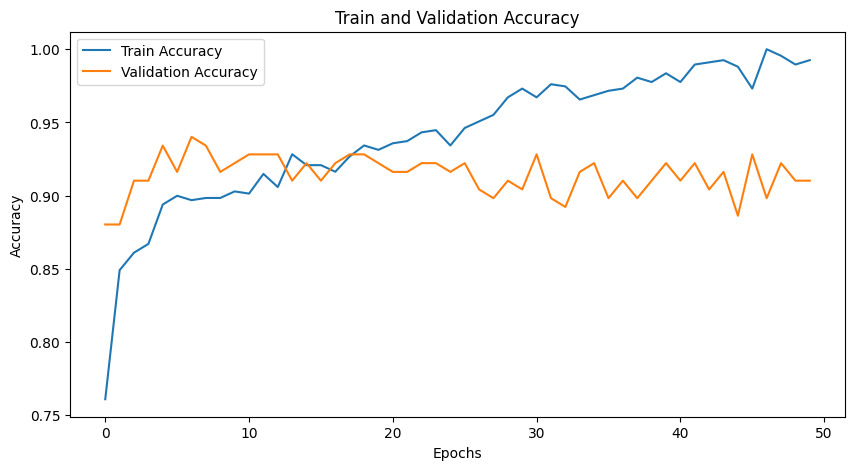

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Load and preprocess the images
data_dir = '/content/SDS/Test'
class_names = ['DR', 'NDR']
img_size = (224, 224)
batch_size = 32
epochs = 50

# Create data generators
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create the data generator for training set
train_data_generator = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True, subset='training'
)

# Create the data generator for validation set
validation_data_generator = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True, subset='validation'
)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer with 2 neurons for 2 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint callback to save best weights based on validation accuracy
best_weights_path = '/content/Split/Save/best_model.keras'
checkpoint = ModelCheckpoint(best_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model and get the training history
history = model.fit(train_data_generator, epochs=epochs, validation_data=validation_data_generator, verbose=1, callbacks=[checkpoint])

# Plot train and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

# Plot train and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.show()


# **Fold#1** Test ResNet-50

In [ ]:
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved best weights
best_weights_path = '/content/Split/Save/best_model.keras'
model.load_weights(best_weights_path)

# Define the dataset directory
TestSet = '/content/SDS/Test'

# Create an ImageDataGenerator for test data
datagen = ImageDataGenerator(rescale=1.0/255)  # You can add other preprocessing steps here

test_data_generator = datagen.flow_from_directory(
    TestSet,
    target_size=img_size,  # Set your target image size (e.g., (224, 224))
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle the test data
)

# Get true labels and predicted labels
y_true = test_data_generator.classes
y_pred = np.argmax(model.predict(test_data_generator), axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Found 836 images belonging to 2 classes.
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step
Test Accuracy: 0.9150717703349283
Test Precision: 0.9157742287544851
Test Recall: 0.9150717703349283
Test F1-score: 0.9151283538660512
Confusion Matrix:
[[398  43]
 [ 28 367]]


## DenseNet201

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import numpy as np
import os
def dense_block(x, blocks, name):
    """A dense block"""
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x

def transition_block(x, reduction, name):
    """A transition block"""
    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1
    x = tf.keras.layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_bn')(x)
    x = tf.keras.layers.Activation('relu', name=name + '_relu')(x)
    x = tf.keras.layers.Conv2D(int(tf.keras.backend.int_shape(x)[bn_axis] * reduction), 1,
                      use_bias=False,
                      name=name + '_conv')(x)
    x = tf.keras.layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x

def conv_block(x, growth_rate, name):
    """A building block for a dense block"""
    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1
    x1 = tf.keras.layers.BatchNormalization(axis=bn_axis,
                                   epsilon=1.001e-5,
                                   name=name + '_0_bn')(x)
    x1 = tf.keras.layers.Activation('relu', name=name + '_0_relu')(x1)
    x1 = tf.keras.layers.Conv2D(4 * growth_rate, 1,
                       use_bias=False,
                       name=name + '_1_conv')(x1)
    x1 = tf.keras.layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x1)
    x1 = tf.keras.layers.Activation('relu', name=name + '_1_relu')(x1)
    x1 = tf.keras.layers.Conv2D(growth_rate, 3,
                       padding='same',
                       use_bias=False,
                       name=name + '_2_conv')(x1)
    x = tf.keras.layers.Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    return x

def DenseNet(blocks, input_shape, num_classes=10):
    img_input = tf.keras.layers.Input(shape=input_shape)

    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1

    x = tf.keras.layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
    x = tf.keras.layers.Conv2D(64, 7, strides=2, use_bias=False, name='conv1\conv')(x)
    x = tf.keras.layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1\bn')(x)
    x = tf.keras.layers.Activation('relu', name='conv1\relu')(x)
    x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, name='pool1')(x)

    x = dense_block(x, blocks[0], name='conv2')
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, blocks[1], name='conv3')
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, blocks[2], name='conv4')
    x = transition_block(x, 0.5, name='pool4')
    x = dense_block(x, blocks[3], name='conv5')

    x = tf.keras.layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = tf.keras.layers.Activation('relu', name='relu')(x)

    x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(x)

    model = tf.keras.models.Model(img_input, x, name='densenet')

    return model

model = DenseNet([6, 12, 48, 32],
                 input_shape=(224, 224, 3),
                 num_classes=5)

model.summary()

Model: "densenet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_7          │ (None, 230, 230, 3)    │              0 │ input_layer_10[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1\conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_7[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1n                    │ (None, 112, 112, 64)   │            256 │ conv1\conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1elu (Activation)     │ (None, 112, 112, 64)   │              0 │ conv1n[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_8          │ (None, 114, 114, 64)   │              0 │ conv1elu[0][0]         │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_8[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 18,331,589 (69.93 MB)

 Trainable params: 18,102,533 (69.06 MB)

 Non-trainable params: 229,056 (894.75 KB)

# **Fold#1** Train DenseNet201

Found 2673 images belonging to 2 classes.
Found 667 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7642 - loss: 0.5535
Epoch 1: val_accuracy improved from -inf to 0.90705, saving model to /content/Split/Save/best_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - accuracy: 0.7659 - loss: 0.5500 - val_accuracy: 0.9070 - val_loss: 0.2484
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8788 - loss: 0.3090
Epoch 2: val_accuracy improved from 0.90705 to 0.93103, saving model to /content/Split/Save/best_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.8787 - loss: 0.3090 - val_accuracy: 0.9310 - val_loss: 0.1991
Epoch 3/50
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9003 - loss: 0.2703
Epoch 3: val_accuracy did not improve from 0.93103
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - accuracy: 0.9002 - loss: 0.2704 - val_accuracy: 0.9295 - val_loss: 0.2101
Epoch 4/50
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8990 - loss: 0.2729
Epoch 4: val_accuracy improved from 0.93103 to 

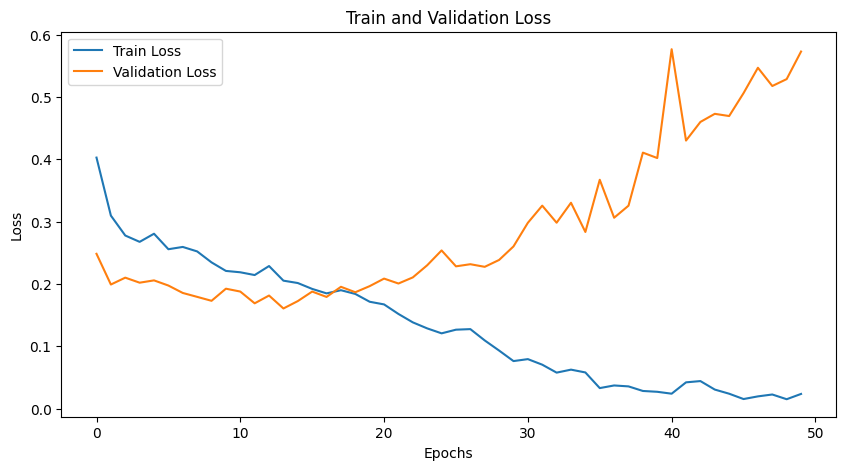

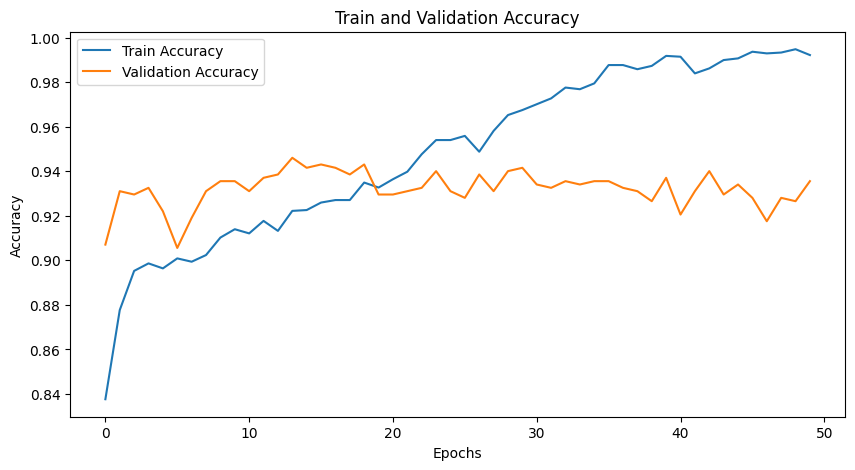

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up paths and parameters
data_dir = '/content/SDS/Train'  # Path to your dataset
img_size = (224, 224)
batch_size = 32
epochs = 50

# Create ImageDataGenerator for training and validation with rescaling
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data generator
train_data_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# Validation data generator
validation_data_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

# Define the CNN model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes: DR and NDR
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint callback to save the best weights
best_weights_path = '/content/Split/Save/best_model.keras'
os.makedirs(os.path.dirname(best_weights_path), exist_ok=True)  # Create directory if it does not exist
checkpoint = ModelCheckpoint(best_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_data_generator,
    epochs=epochs,
    validation_data=validation_data_generator,
    verbose=1,
    callbacks=[checkpoint]
)

# Plot train and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

# Plot train and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.show()


# **Fold#1** Test DenseNet201

In [ ]:
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved best weights
best_weights_path = '/content/Split/Save/best_model.keras'
model.load_weights(best_weights_path)

# Define the dataset directory
TestSet = '/content/SDS/Test'


# Create an ImageDataGenerator for test data
datagen = ImageDataGenerator(rescale=1.0/255)  # You can add other preprocessing steps here

test_data_generator = datagen.flow_from_directory(
    TestSet,
    target_size=img_size,  # Set your target image size (e.g., (224, 224))
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle the test data
)

# Get true labels and predicted labels
y_true = test_data_generator.classes
y_pred = np.argmax(model.predict(test_data_generator), axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Found 836 images belonging to 2 classes.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
Test Accuracy: 0.916267942583732
Test Precision: 0.916743608131168
Test Recall: 0.916267942583732
Test F1-score: 0.9163169044884901
Confusion Matrix:
[[400  41]
 [ 29 366]]


## Inception V3

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, BatchNormalization, Concatenate, Input

def inception_block(x, filters):
    # 1x1 Convolution
    path1 = Conv2D(filters[0], (1, 1), activation='relu')(x)

    # 1x1 Convolution followed by 3x3 Convolution
    path2 = Conv2D(filters[1], (1, 1), activation='relu')(x)
    path2 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(path2)

    # 1x1 Convolution followed by 5x5 Convolution
    path3 = Conv2D(filters[3], (1, 1), activation='relu')(x)
    path3 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(path3)

    # 3x3 MaxPooling followed by 1x1 Convolution
    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters[5], (1, 1), activation='relu')(path4)

    # Concatenate the output of all paths
    return Concatenate()([path1, path2, path3, path4])

def build_inception_v3(input_shape=(299, 299, 3), num_classes=5):
    inputs = Input(shape=input_shape)

    # Stem
    x = Conv2D(32, (3, 3), strides=(2, 2), activation='relu')(inputs)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Inception Blocks
    x = inception_block(x, filters=[64, 128, 128, 128, 256, 256])
    x = inception_block(x, filters=[128, 192, 192, 192, 384, 384])
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Add more inception blocks as per the original Inception V3 architecture

    # Final layers
    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=x, name='inception_v3')

    return model

# Create the Inception V3 model
inception_v3_model = build_inception_v3(input_shape=(224, 224, 3))

# Show model summary
inception_v3_model.summary()
model=inception_v3_model

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 111, 111, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 109, 109, 32)   │          9,248 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 109, 109, 64)   │         18,496 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 54, 54, 64)     │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 54, 54, 128)    │          8,320 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 54, 54, 128)    │          8,320 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 54, 54, 64)     │              0 │ max_pooling2d_6[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 54, 54, 64)     │          4,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 54, 54, 128)    │        147,584 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 54, 54, 256)    │        819,456 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 54, 54, 256)    │         16,640 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 54, 54, 704)    │              0 │ conv2d_9[0][0],        │
│                           │                        │                │ conv2d_11[0][0],       │
│                           │                        │                │ conv2d_13[0][0],       │
│                           │                        │                │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 54, 54, 192)    │        135,360 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 54, 54, 192)    │        135,360 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 54, 54, 704)    │              0 │ concatenate[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 3,889,317 (14.84 MB)

 Trainable params: 3,889,317 (14.84 MB)

 Non-trainable params: 0 (0.00 B)

# **Fold#1** Train Inception V3

Found 2673 images belonging to 2 classes.
Found 667 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7759 - loss: 0.5065
Epoch 1: val_accuracy improved from -inf to 0.93253, saving model to /content/Split/Save/best_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 238ms/step - accuracy: 0.7767 - loss: 0.5051 - val_accuracy: 0.9325 - val_loss: 0.2320
Epoch 2/50
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8796 - loss: 0.3294
Epoch 2: val_accuracy did not improve from 0.93253
84/84 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - accuracy: 0.8796 - loss: 0.3290 - val_accuracy: 0.9175 - val_loss: 0.2660
Epoch 3/50
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8832 - loss: 0.3024
Epoch 3: val_accuracy improved from 0.93253 to 0.93703, saving model to /content/Split/Save/best_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - accuracy: 0.8834 - loss: 0.3019 - val_accuracy: 0.9370 - val_loss: 0.2100
Epoch 4/50
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9087 - loss: 0.2541
Epoch 4: val_accuracy did not improve from 0.93703

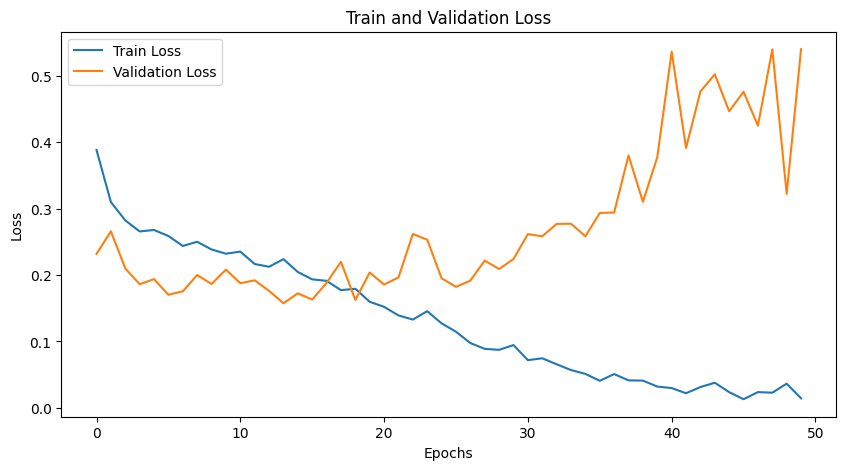

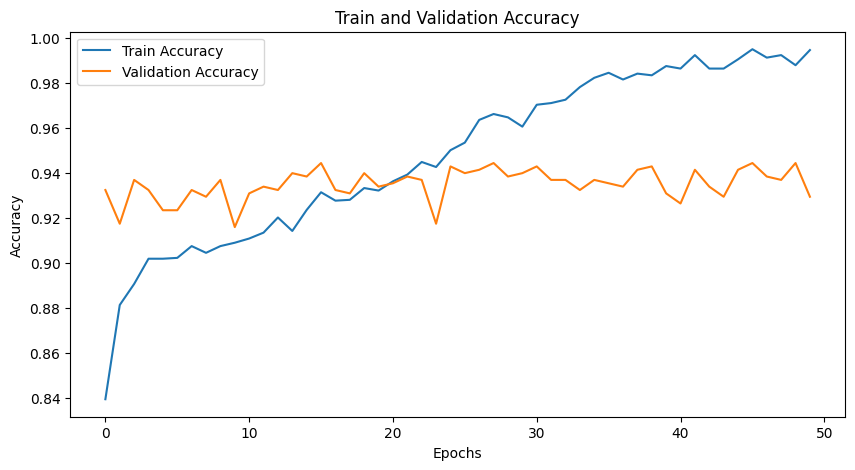

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up paths and parameters
data_dir = '/content/SDS/Train'  # Path to your dataset
img_size = (224, 224)
batch_size = 32
epochs = 50

# Create ImageDataGenerator for training and validation with rescaling
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data generator
train_data_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# Validation data generator
validation_data_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

# Define the CNN model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes for DR and NDR
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint callback to save the best weights
best_weights_path = '/content/Split/Save/best_model.keras'
os.makedirs(os.path.dirname(best_weights_path), exist_ok=True)  # Create directory if it does not exist
checkpoint = ModelCheckpoint(best_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_data_generator,
    epochs=epochs,
    validation_data=validation_data_generator,
    verbose=1,
    callbacks=[checkpoint]
)

# Plot train and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

# Plot train and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.show()


# **Fold#1** Test Inception V3

In [ ]:
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved best weights
best_weights_path = '/content/Split/Save/best_model.keras'
model.load_weights(best_weights_path)

# Define the dataset directory
TestSet = '/content/SDS/Test'

# Create an ImageDataGenerator for test data
datagen = ImageDataGenerator(rescale=1.0/255)  # You can add other preprocessing steps here

test_data_generator = datagen.flow_from_directory(
    TestSet,
    target_size=img_size,  # Set your target image size (e.g., (224, 224))
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle the test data
)

# Get true labels and predicted labels
y_true = test_data_generator.classes
y_pred = np.argmax(model.predict(test_data_generator), axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Found 836 images belonging to 2 classes.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
Test Accuracy: 0.9090909090909091
Test Precision: 0.9091453196699998
Test Recall: 0.9090909090909091
Test F1-score: 0.9090344811371277
Confusion Matrix:
[[407  34]
 [ 42 353]]


Found 3340 images belonging to 2 classes.
Found 836 images belonging to 2 classes.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


418/418 ━━━━━━━━━━━━━━━━━━━━ 703s 864ms/step - accuracy: 0.8248 - loss: 5.6539 - val_accuracy: 0.9713 - val_loss: 3.3662 - learning_rate: 1.0000e-04
Epoch 2/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 138s 254ms/step - accuracy: 0.9209 - loss: 3.1822 - val_accuracy: 0.9653 - val_loss: 2.2908 - learning_rate: 1.0000e-04
Epoch 3/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 102s 242ms/step - accuracy: 0.9312 - loss: 2.1951 - val_accuracy: 0.9689 - val_loss: 1.5917 - learning_rate: 1.0000e-04
Epoch 4/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 103s 243ms/step - accuracy: 0.9438 - loss: 1.5424 - val_accuracy: 0.9665 - val_loss: 1.1445 - learning_rate: 1.0000e-04
Epoch 5/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 146s 254ms/step - accuracy: 0.9620 - loss: 1.0827 - val_accuracy: 0.9641 - val_loss: 0.8567 - learning_rate: 1.0000e-04
Epoch 6/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 107s 251ms/step - accuracy: 0.9574 - loss: 0.8070 - val_accuracy: 0.9593 - val_loss: 0.6316 - learning_rate: 1.0000e-04
Epoch 7/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 103s 244ms/

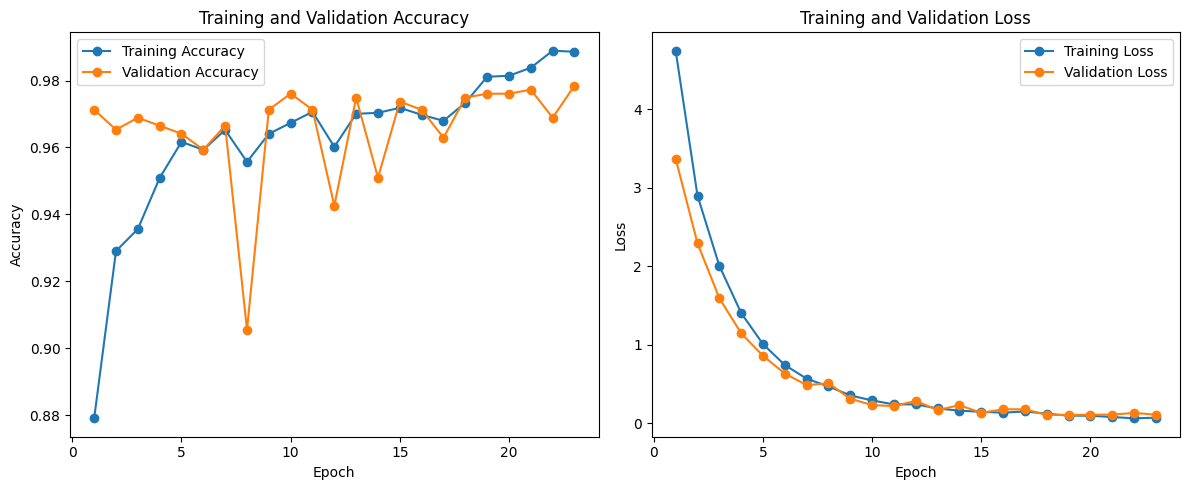

Saved model weights to /content/SDS/final_model_weights.weights.h5
105/105 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step

Classification Report:
               precision    recall  f1-score   support

          DR       0.98      0.97      0.98       441
         NDR       0.97      0.98      0.97       395

    accuracy                           0.97       836
   macro avg       0.97      0.98      0.97       836
weighted avg       0.97      0.97      0.97       836



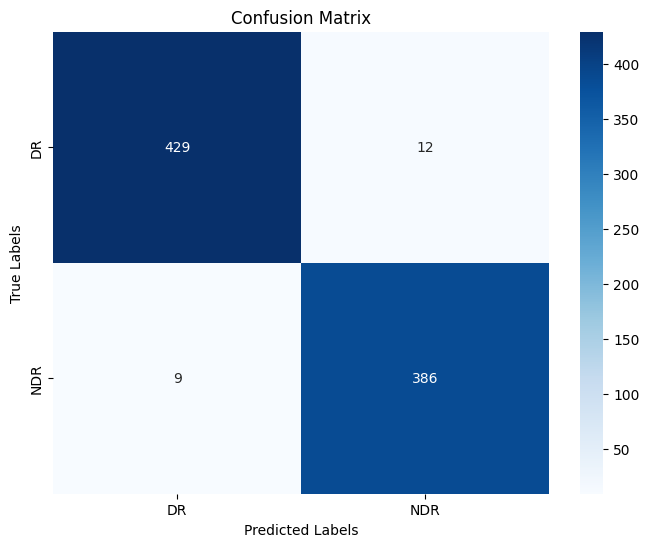

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2, DenseNet169
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ================================
# 1. Set Random Seeds for Reproducibility
# ================================
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# ================================
# 2. Define Constants and Paths
# ================================
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 8  # Smaller batch size for better generalization
NUM_CLASSES = 2  # Change based on your dataset's number of classes
EPOCHS = 50
INITIAL_LR = 1e-4  # Reduced initial learning rate to avoid large initial loss

# Use the paths from the previous code
TRAIN_DIR = '/content/SDS/Train'  # Training data directory
VALID_DIR = '/content/SDS/Test'  # Validation data directory
DRIVE_MODEL_PATH = '/content/SDS'

# Ensure the directory exists for saving outputs
os.makedirs(DRIVE_MODEL_PATH, exist_ok=True)

# ================================
# 3. Create Data Generators with Augmentation
# ================================
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    TRAIN_DIR,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_generator = datagen_val.flow_from_directory(
    VALID_DIR,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ================================
# 4. Build a Simplified Multi-Branch Model with Moderate Regularization
# ================================

def build_model():
    inputs = Input(shape=INPUT_SHAPE, name="main_input")

    # Instantiate only two base models to reduce complexity
    resnet_base = ResNet50V2(weights='imagenet', include_top=False, pooling='avg', name='resnet_base')
    densenet_base = DenseNet169(weights='imagenet', include_top=False, pooling='avg', name='densenet_base')

    # Pass the input through each model independently
    resnet_out = resnet_base(inputs)
    densenet_out = densenet_base(inputs)

    # Concatenate the outputs of the models
    combined = Concatenate(name='concatenate')([resnet_out, densenet_out])

    # Add fully connected layers with reduced L2 regularization and dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01), name='fc1')(combined)
    x = Dropout(0.5, name='dropout1')(x)  # Moderate dropout rate
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01), name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)

    output = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

    # Define inputs and outputs in the final model
    model = Model(inputs=inputs, outputs=output, name='RegularizedMultiBranchModel')
    return model

# Build and compile the model
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ================================
# 5. Training with Early Stopping and Learning Rate Reduction
# ================================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction on plateau
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, lr_reduction],
    verbose=1
)

# ================================
# Plot Training and Validation Accuracy and Loss
# ================================

def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label="Training Accuracy", marker='o')
    plt.plot(epochs, val_acc, label="Validation Accuracy", marker='o')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label="Training Loss", marker='o')
    plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# ================================
# Save the Model Weights
# ================================
model.save_weights(os.path.join(DRIVE_MODEL_PATH, 'final_model_weights.weights.h5'))
print(f'Saved model weights to {os.path.join(DRIVE_MODEL_PATH, "final_model_weights.weights.h5")}')

# ================================
# 6. Model Evaluation on Validation Set
# ================================
# Get predictions on the validation set
valid_generator.reset()  # Reset the validation generator for proper predictions
predictions = model.predict(valid_generator, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels
true_classes = valid_generator.classes

# Calculate classification report (precision, recall, F1-score)
report = classification_report(true_classes, predicted_classes, target_names=train_generator.class_indices)
print("\nClassification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()
